In [1]:
import os
import cv2
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def load_images_with_hog(base_folder,
                         pixels_per_cell=(8,8),
                         cells_per_block=(2,2),
                         orientations=9,
                         use_pca=False,
                         n_components=150):
    hog_list = []
    labels   = []

    for label in ["plastic", "no-plastic"]:
        folder = os.path.join(base_folder, label)
        for fname in os.listdir(folder):
            path = os.path.join(folder, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            
            img = cv2.resize(img, (256,256)).astype("float32") / 255.0

            
            features = hog(
                img,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys',
                feature_vector=True
            )
            hog_list.append(features)
            labels.append(1 if label=="plastic" else 0)

    X_hog = np.array(hog_list)  
    y     = np.array(labels)

    if not use_pca:
        return X_hog, y

    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_hog)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, y, scaler, pca

In [3]:

X_train, y_train = load_images_with_hog("SOUVIK/train")
X_test, y_test = load_images_with_hog("SOUVIK/test")

In [4]:
print(f"Treino: {X_train.shape}, Rótulos: {y_train.shape}")
print(f"Teste: {X_test.shape}, Rótulos: {y_test.shape}")

Treino: (1720, 34596), Rótulos: (1720,)
Teste: (430, 34596), Rótulos: (430,)


In [5]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)

SVC()

In [6]:
y_pred_svc = svc.predict(X_test)
class_rep = classification_report(y_test, y_pred_svc)
print(f"Classification Report")
print(class_rep)

cm = confusion_matrix(y_test, y_pred_svc)
print(f"Confusion Matrix")
print(cm)
print(f"TN: {cm[0][0]} | FN: {cm[0][1]} | FP: {cm[1][0]} | TP: {cm[1][1]}")

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       220
           1       0.71      0.85      0.77       210

    accuracy                           0.75       430
   macro avg       0.76      0.76      0.75       430
weighted avg       0.76      0.75      0.75       430

Confusion Matrix
[[146  74]
 [ 32 178]]
TN: 146 | FN: 74 | FP: 32 | TP: 178


In [7]:
import pickle

# Salve o modelo em um arquivo
filename = 'svm_model.pkl'
pickle.dump(svc, open(filename, 'wb'))

print(f"Modelo KNN exportado para {filename}")

Modelo KNN exportado para svm_model.pkl


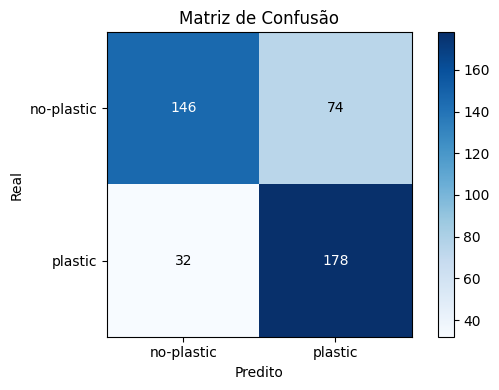

In [10]:
# ...existing code...
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Supondo que você já tenha y_test e y_pred_svc
cm = confusion_matrix(y_test, y_pred_svc)

fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
cbar = ax.figure.colorbar(im, ax=ax)

# Anotar células com os valores
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(int(cm[i, j]), 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax.set_title("Matriz de Confusão")
ax.set_xlabel("Predito")
ax.set_ylabel("Real")

# Colocar rótulos para as classes (0 = Negativo, 1 = Positivo)
classes = ["no-plastic", "plastic"]
ax.set_xticks([0, 1])
ax.set_xticklabels(classes)
ax.set_yticks([0, 1])
ax.set_yticklabels(classes)

plt.tight_layout()
plt.show()
# ...existing code...